# 特徴量

* 商品情報
* 店舗情報
* 日付

# アルゴリズム

* XgBoost

* * *

# 結果

0.273164105402257

## import

In [1]:
% matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import bokeh.plotting as bplt
from IPython.display import display, HTML
from pprintpp import pprint as pp
import xgboost as xgb
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

bplt.output_notebook()

OSError: dlopen(/Users/iwasawa/penv1/lib/python2.7/site-packages/xgboost/./wrapper/libxgboostwrapper.so, 6): Library not loaded: /usr/local/lib/gcc/5/libgomp.1.dylib
  Referenced from: /Users/iwasawa/penv1/lib/python2.7/site-packages/xgboost/./wrapper/libxgboostwrapper.so
  Reason: image not found

In [ ]:
datanames  = ['product', 'sales', 'store', 'test', 'train']
sex = ['m', 'w']
age = ['00_19', '20_49', '50_']
segments = ['m00_19', 'm20_49', 'm50_', 'w00_19', 'w20_49', 'w50_']
pids = ['p000', 'p001', 'p002', 'p003', 'p004', 'p005', 'p006', 'p007',
       'p008', 'p009', 'p010', 'p011', 'p012', 'p013', 'p014', 'p015',
       'p016', 'p017', 'p018', 'p019', 'p020', 'p021', 'p022', 'p023',
       'p024', 'p025', 'p026', 'p027', 'p028', 'p029', 'p030', 'p031',
       'p032', 'p033', 'p034', 'p035', 'p036', 'p037', 'p038', 'p039',
       'p040', 'p041', 'p042', 'p043', 'p044', 'p045', 'p046', 'p047',
       'p048', 'p049', 'p050', 'p051', 'p052', 'p053', 'p054', 'p055',
       'p056', 'p057', 'p058', 'p059', 'p060', 'p061', 'p062', 'p063',
       'p064', 'p065', 'p066', 'p067', 'p068', 'p069', 'p070', 'p071',
       'p072']
train_dates = [201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605]
store_catecol = ['area', 'location']
size_dict = {'size_g': 'g', 'size_stick':'本', 'size_piece':'個', 'size_sheet':'枚'}
# 本 -> stick for index[50] , 個 -> stick for index[14, 15, 25, 37] , 枚 -> stick for index[27, 28] 
product_catecol = ['category', 'package_type', 'genre', 'manufacturer']
product_apeals = ['cal', '食物繊維', '乳酸菌', 'オリーブオイル', '砂糖', '糖類', '糖質', '食塩']
allergys= ['allergy_egg', 'allergy_wheat', 'allergy_milk', 'allergy_peanut', 'allergy_shrimp']

In [ ]:
df_dict_origin = {datanames[n] : pd.read_csv('../data/{}.tsv'.format(name), delimiter='\t') for n, name in enumerate(datanames)}
df_dict = {name : df_dict_origin[name].copy() for name in df_dict_origin}

## Pre-paration

### store's categorical variables -> dummy

* store_catecol = ['area', 'location']のダミー変数を生成
* store_catecol = ['area', 'location']をドロップ

In [ ]:
for df_n in ['train', 'test', 'store']:
    for col in store_catecol:
        dummy = pd.get_dummies(df_dict[df_n][col])
        df_dict[df_n] = pd.concat((df_dict[df_n], dummy), axis=1)
    df_dict[df_n] = df_dict[df_n].drop(store_catecol, axis =1)

### 商品のサイズ種類

* [g, 枚, 個, 本]にカテゴライズ
* 対応するものにfloatで保管
* 違うカラムには０を保存

In [ ]:
df_n = 'product'
col_n = 'size'
entity = 'g'

df_dict[df_n][df_dict[df_n][col_n].str.contains(entity).apply(lambda x: False if x else True)][col_n]

In [ ]:
df_n = 'product'
col_n = 'size'
decode_n = 'utf-8'
dtype_d = 'float64'

for size_n in size_dict:
    df_dict[df_n][size_n] = df_dict[df_n][col_n].apply(lambda x: x.decode(decode_n)[:-1]).astype(dtype_d)
    df_dict[df_n].loc[df_dict[df_n][col_n].str.contains(size_dict[size_n]).apply(lambda x: False if x else True), size_n] = 0
df_dict[df_n] = df_dict[df_n].drop(col_n, axis=1)

### 商品のカテゴリカル変数 -> ダミー変数

* category :  [おやつごろシリーズ菓子, ナチュラルローソン菓子]
* package_type : [カップ, 箱, 袋]
* genre : (total 24)[u'クッキー', u'クラッカー', u'スナック菓子', u'チョコレート', u'チョコレート菓子', u'ドーナツ', u'パイ', u'パイ加工品', u'ビスケット', u'ポテトチップス', u'マシュマロ', u'ラスク', u'半生菓子', u'有機干し芋', u'油菓子', u'準チョコレート', u'焼菓子', u'種実加工品', u'米菓', u'米菓子', u'菓子', u'野菜チップス', u'魚介乾製品', u'魚介加工品']
* manufacturer : (total 40) [u'ぼんち株式会社', u'イケダヤ製菓株式会社', u'イトウ製菓株式会社', u'カバヤ食品株式会社', u'カルビー株式会社',u'ジャパンフリトレー株式会社', u'ダイシンフーズ株式会社', u'ニッポー株式会社', u'ハース株式会社', u'ホンダ製菓株式会社',u'リスカ株式会社', u'ローヤル製菓株式会社', u'久保田製菓有限会社', u'宝製菓株式会社', u'旺旺ジャパン株式会社',u'東京カリント株式会社', u'株式会社おやつカンパニー', u'株式会社エイワ', u'株式会社オリーヴ', u'株式会社カレイナ',u'株式会社ギンビス', u'株式会社ニッコー', u'株式会社ミツヤ', u'株式会社リボン', u'株式会社ロッテ',u'株式会社不二家', u'株式会社北食', u'株式会社合食', u'株式会社壮関', u'株式会社天乃屋', u'株式会社末広製菓',u'株式会社村田製菓', u'株式会社東ハト', u'株式会社栗山米菓', u'株式会社正栄デリシィ', u'株式会社湖池屋',u'株式会社道南冷蔵', u'森永製菓株式会社', u'江崎グリコ株式会社', u'阿部幸製菓株式会社']

In [ ]:
df_n = 'product'
for col in product_catecol:
    dummy = pd.get_dummies(df_dict[df_n][col])
    df_dict[df_n] = pd.concat((df_dict[df_n], dummy), axis=1)
df_dict[df_n] = df_dict[df_n].drop(product_catecol, axis =1)

### 商品のアピールポイント -> ダミー変数

* [cal, 食物繊維, 乳酸菌, オリーブオイル, 砂糖, 糖類, 糖質, 食塩]
* アピールポイントに上記のワードを含む商品にフラグをたてる

In [ ]:
df_dict[df_n].appeal_point[df_dict[df_n].appeal_point.apply(pd.notnull)]

In [ ]:
df_n = 'product'
col_n = 'appeal_point'

df_dict[df_n][col_n] = df_dict[df_n][col_n].fillna(value='tmp')
for word in product_apeals:
    df_dict[df_n][word] = df_dict[df_n].appeal_point.apply(lambda x: 1 if word in x else 0)
df_dict[df_n] = df_dict[df_n].drop(col_n, axis =1)


### アレルギー情報の0補間

In [ ]:
df_n = 'product'

for col_n in allergys:
    df_dict[df_n][col_n] = df_dict[df_n][col_n].fillna(0)

### 説明文の有無フラグ

In [ ]:
df_n = 'product'
col_n = 'description'

df_dict[df_n][col_n] =  df_dict[df_n][col_n].apply(lambda x: 0 if pd.isnull(x) else 1)

### 原材料のダミー変数

* エンコードがうまくいかない
* カラム数が膨大
* 以上の理由より一時放置

In [ ]:
pd.isnull(df_dict['product'].materials).value_counts()

In [ ]:
pp([unicode(word, 'utf-8') for word in df_dict['product'].materials[1].split('、')])

### 栄養成分量

* 欠損値は0補間
* 範囲表示のものは中間の値を使用

In [ ]:
df_n = 'product'
_split = '\xef\xbd\x9e'
_type = np.float
colkey = 'nutrition'
type_key = 'object'

for col in df_dict[df_n].columns:
    if colkey in col:
        df_dict[df_n][col] = df_dict[df_n][col].fillna(value=0)
        if df_dict[df_n][col].dtype == type_key:
            _TrueFalse = df_dict[df_n][col].str.contains(_split).fillna(value=False)
            inds = df_dict[df_n][_TrueFalse][col].index
            for i in inds:
                df_dict[df_n].loc[i, col] = np.array(df_dict[df_n][col][i].split(_split)).astype(np.float).mean()
            df_dict[df_n][col] = df_dict[df_n][col].astype(_type)

### 概要文と原材料をドロップ

In [ ]:
drop_col = ['abstract', 'materials', 'pname']
df_n = 'product'

df_dict[df_n] = df_dict[df_n].drop(drop_col, axis=1)

### date to int

In [ ]:
df_n = 'product'
df_dict[df_n]

## typeがintやfloatになっているのか確認

In [2]:
for df_n in datanames:
    print '#######{}######'.format(df_n)
    for n, t in enumerate(df_dict[df_n].dtypes):
        if t == 'object':
            print [df_dict[df_n].columns[n], df_dict[df_n].dtypes[n]]

NameError: name 'datanames' is not defined

## pidでproduct_dfと[train_df, test_df]をマージ

In [3]:
main_dfs = ['train', 'test']
subdf_dict = {'pid': 'product'}
_how = 'left'

for df_n in main_dfs:
    for _id in subdf_dict:
        df_dict[df_n] = df_dict[df_n].merge(df_dict[subdf_dict[_id]], how=_how, on=_id).drop(_id, axis=1)

NameError: name 'df_dict' is not defined

## クロスバリデーション

In [4]:
df_n = 'train'
label = 'y'
train_X = df_dict[df_n].drop(label, axis=1).values
train_Y = np.log(1+df_dict[df_n][label]).values[:, np.newaxis]

df_n = 'test'
drop_col = 'id'
test_X = df_dict[df_n].drop(drop_col, axis=1).values

NameError: name 'df_dict' is not defined

In [5]:
train_Y

NameError: name 'train_Y' is not defined

In [6]:
params = params={
    'max_depth': [2, 3],
    'learning_rate': [0.3],
    'n_estimators': [100],
    'min_child_weight': [1],
    'gamma': [0.0],
    'max_delta_step': [0],
    'subsample': [0.95],
    'colsample_bytree': [1.0],
    'reg_lambda': [1],
    'reg_alpha': [0],
    'scale_pos_weight': [1]
}
xgb_model = xgb.XGBRegressor(
    silent=0, nthread=1, objective='reg:linear', seed=27
)

gs = GridSearchCV(xgb_model,
                  params,
                  cv=10,
                  scoring='mean_squared_error',
                  n_jobs = -1
                 )
gs.fit(train_X,train_Y)

print "\n+ ベストパラメータ:\n"
print gs.best_estimator_

print"\n+ トレーニングデータでCVした時の平均スコア:\n"
for params, mean_score, all_scores in gs.grid_scores_:
    print "{:.3f} (+/- {:.3f}) for {}".format(mean_score, all_scores.std() / 2, params)

predict = gs.predict(test_X)


NameError: name 'xgb' is not defined

In [7]:
pd.Series(np.exp(predict)-1).to_csv('../report/sample_submit.csv')

NameError: name 'predict' is not defined

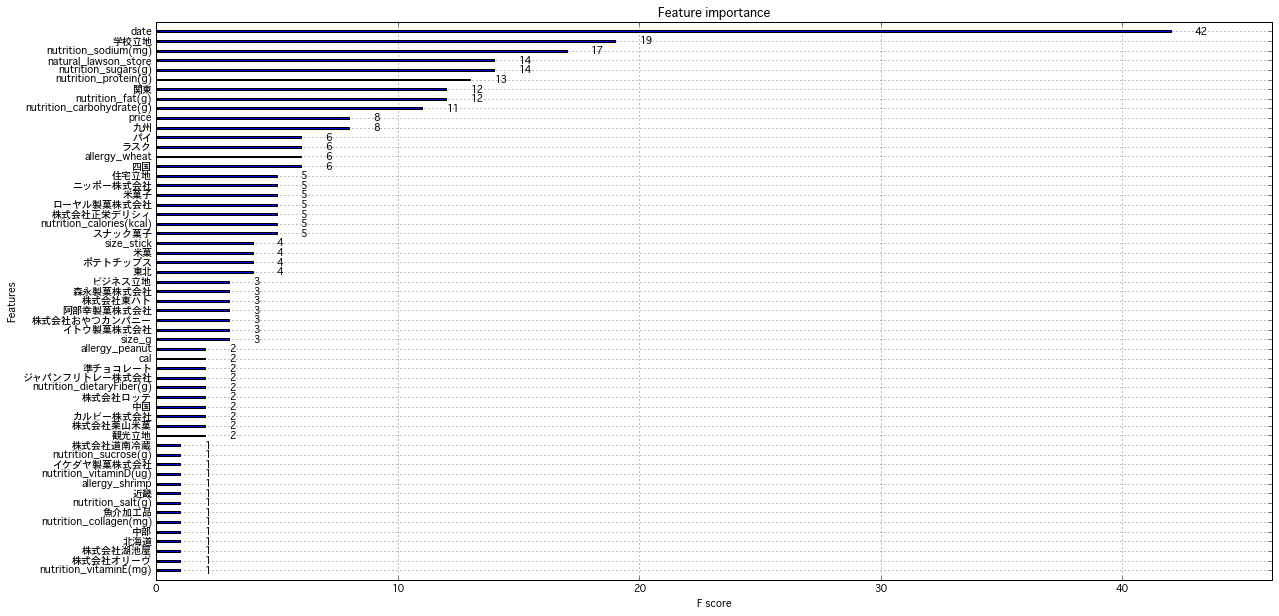

In [42]:
gs.best_estimator_.booster().get_fscore()

mapper = {'f{0}'.format(i): v for i, v in enumerate(df_dict[df_n].drop(drop_col, axis=1).columns)}
mapped = {mapper[k].decode('utf-8'): v for k, v in gs.best_estimator_.booster().get_fscore().items()}

plt.rcParams['font.family'] = 'Osaka'
fig = plt.figure(figsize =[20,10])
ax = fig.add_subplot(111)
xgb.plot_importance(mapped, ax=ax)